In [1]:
import pickle as pkl
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram
from src.training.training import load_model

2024-03-12 13:59:30.491347: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 13:59:30.518146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 13:59:30.518179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 13:59:30.518833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 13:59:30.522958: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 13:59:30.523469: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(base_model)

mixture_folder = folder + 'mixture/'

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



In [3]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.feature_names, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 5)


In [4]:
### laoding of the tn_gev mixture models

crps = load_model(mixture_folder + 'mixture_tn_gev_crps__epochs200.pkl')
mean12_std4 = load_model(mixture_folder + 'mixture_tn_gev_twcrps_mean12.0_std4.0_epochs200.pkl')
mean16_std4 = load_model(mixture_folder + 'mixture_tn_gev_twcrps_mean16.0_std4.0_epochs200.pkl')
mean16_std6 = load_model(mixture_folder + 'mixture_tn_gev_twcrps_mean16.0_std6.0_epochs200.pkl')
mean12_std1 = load_model(mixture_folder + 'mixture_tn_gev_twcrps_mean12.0_std1.0_epochs200.pkl')

tn_gev = {'crps': crps, 'mean12_std4': mean12_std4, 'mean16_std4': mean16_std4, 'mean16_std6': mean16_std6, 'mean12_std1': mean12_std1}

Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution


In [5]:
### loading of the tn_frechet mixture models

crps = load_model(mixture_folder + 'mixture_tn_frechet_crps__epochs200.pkl')
mean12_std1 = load_model(mixture_folder + 'mixture_tn_frechet_twcrps_mean12.0_std1.0_epochs200.pkl')
mean16_std5 = load_model(mixture_folder + 'mixture_tn_frechet_twcrps_mean16.0_std5.0_epochs200.pkl')
mean12_std4 = load_model(mixture_folder + 'mixture_tn_frechet_twcrps_mean12.0_std4.0_epochs200.pkl')

tn_frechet = {'crps': crps, 'mean12_std1': mean12_std1, 'mean16_std5': mean16_std5, 'mean12_std4': mean12_std4}

Using given parameters for Truncated Normal distribution
Using given parameters for Frechet distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Frechet distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Frechet distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Frechet distribution
Using given weight parameter for Mixture distribution


In [7]:
all_models = {**tn_gev, **tn_frechet}

In [6]:
samples = 2000

print('Base model CRPS: ', base_model.loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())
for key, model in tn_gev.items():
    print(key, ' tn gev CRPS: ', model.loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

for key, model in tn_frechet.items():
    print(key, ' tn frechet CRPS: ', model.loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

Base model CRPS:  0.89075416
crps  tn gev CRPS:  0.8840745
mean12_std4  tn gev CRPS:  0.8939635
mean16_std4  tn gev CRPS:  0.9245116
mean16_std6  tn gev CRPS:  0.88901895
mean12_std1  tn gev CRPS:  1.0804698
crps  tn frechet CRPS:  0.8847391
mean12_std1  tn frechet CRPS:  1.0495105
mean16_std5  tn frechet CRPS:  0.8959981
mean12_std4  tn frechet CRPS:  0.8922783


There are 7780 values in the PIT diagram


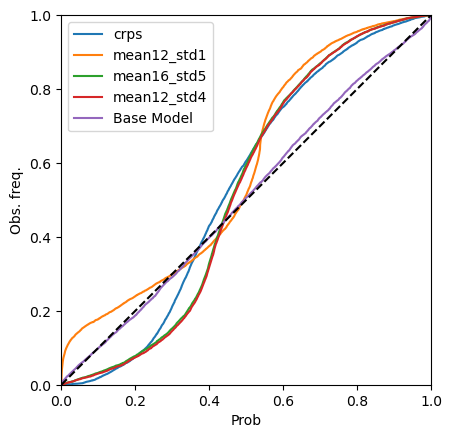

In [18]:
t = 0
make_cpit_diagram_emos(tn_frechet, X_test, y_test, variances_test, t=t, base_model=base_model)

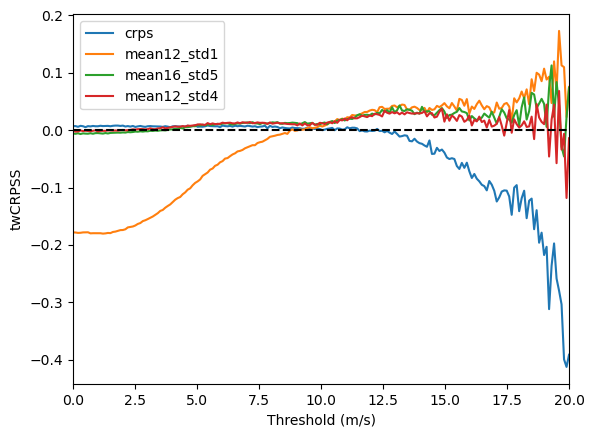

In [17]:
x_values = np.linspace(0, 20, 200)
make_twcrpss_plot(base_model, tn_frechet, X_test, y_test, variances_test, x_values, sample_size=2000)

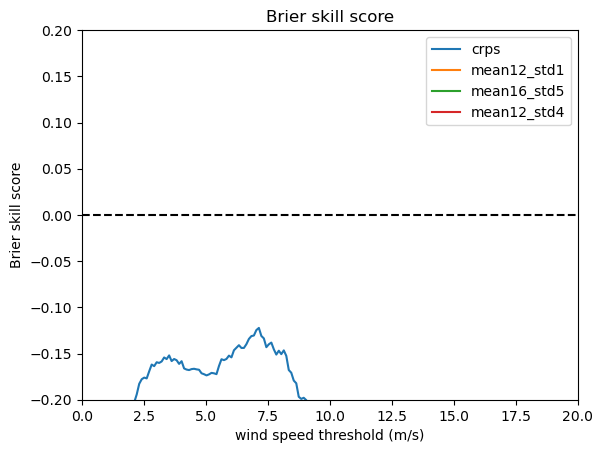

In [19]:
ylim = [-0.2, 0.2]
brier_skill_plot(base_model, tn_frechet, X_test, y_test, variances_test, x_values, ylim=ylim)